<h1>Example: Bit Pattern Set</h1>

The dataset of this demonstration falls into the category of <i>binary classification</i> tasks in the domain of <i>Multiple Instance Learning (MIL)</i> problems. Each bag comprises a collection of bit pattern instances, wheres each instance is a sequence of <b>0s</b> and <b>1s</b>. The positive class has specific bit patterns injected, which are absent in the negative one. This demonstration shows, that <code>Hopfield</code> and <code>HopfieldPooling</code> are capable of learning and filtering each bag with respect to the class-defining bit patterns.

This demonstration instructs how to apply <code>Hopfield</code> and <code>HopfieldPooling</code> for an exemplary Multiple Instance Learning problem.

<h3 style="color:rgb(208,90,80)">In the chapters <a href="#Adapt-Hopfield-based-Network">Adapt Hopfield-based Network</a> and <a href="#Adapt-Hopfield-based-Pooling">Adapt Hopfield-based Pooling</a> you can explore and try the new functionalities of our new Hopfield layer.</h3>

In order to run this notebook, a few modules need to be imported. The installation of third-party modules is <i>not</i> covered here.

In [1]:
# Import general modules used e.g. for plotting.
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import sys
import torch

# Importing Hopfield-specific modules.
from auxiliary.data import BitPatternSet
from modules import Hopfield, HopfieldPooling

# Import auxiliary modules.
from distutils.version import LooseVersion
from typing import List, Tuple

# Importing PyTorch specific modules.
from torch import Tensor
from torch.nn import Flatten, Linear, Module, Sequential
from torch.nn.functional import binary_cross_entropy_with_logits
from torch.nn.utils import clip_grad_norm_
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

# Set plotting style.
sns.set()

Specific minimum versions of Python itself as well as of some used modules is required.

In [2]:
python_check = '(\u2713)' if sys.version_info >= (3, 8) else '(\u2717)'
pytorch_check = '(\u2713)' if torch.__version__ >= LooseVersion(r'1.5') else '(\u2717)'

print(f'Installed Python version:  {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro} {python_check}')
print(f'Installed PyTorch version: {torch.__version__} {pytorch_check}')

Installed Python version:  3.8.5 (✓)
Installed PyTorch version: 1.6.0 (✓)


<h3 style="color:rgb(0,120,170)">Create Dataset</h3>

The dataset itself falls into the category of <i>binary classification</i> tasks in the domain of <i>Multiple Instance Learning (MIL)</i> problems. Defining arguments are:
<br><br>
<table>
    <tr>
        <th>Argument</th>
        <th>Value (used in this demo)</th>
        <th>Description</th>
    </tr>
    <tr>
        <th><code>num_bags</code></th>
        <th>2048</th>
        <th>Amount of bags (samples) of the full dataset.</th>
    </tr>
    <tr>
        <th><code>num_instances</code></th>
        <th>16</th>
        <th>Amount of instances <i>per</i> bag (sample).</th>
    </tr>
    <tr>
        <th><code>num_signals</code></th>
        <th>8</th>
        <th>Amount of unique instances indicative for the positive class.</th>
    </tr>
    <tr>
        <th><code>num_signals_per_bag</code></th>
        <th>1</th>
        <th>Amount of signals implanted into one bag of a positive class.</th>
    </tr>
    <tr>
        <th><code>num_bits</code></th>
        <th>8</th>
        <th>Amount of "bits" (feature size) per instance.</th>
    </tr>
    <tr>
        <th><code>...</code></th>
        <th>default</th>
        <th>The remaining arguments are not explicitly used in this demo.</th>
    </tr>
</table>

Let's define the dataset using previously mentioned properties as well as a logging directory for storing all auxiliary outputs like performance plots.

In [3]:
bit_pattern_set = BitPatternSet(
    num_bags=2048,
    num_instances=16,
    num_signals=8,
    num_signals_per_bag=1,
    num_bits=8)

In [4]:
log_dir = f'resources/'
os.makedirs(log_dir, exist_ok=True)

<h3 style="color:rgb(0,120,170)">Create Auxiliaries</h3>

Before digging into Hopfield-based networks, a few auxiliary variables and functions need to be defined. This is nothing special with respect to Hopfield-based networks, but rather common preparation work of (almost) every machine learning setting (e.g. definition of a <i>data loader</i> as well as a <i>training loop</i>). We will see, that this comprises the most work of this whole demo.

In [5]:
device = torch.device(r'cuda:0' if torch.cuda.is_available() else r'cpu')

# Create data loader of training set.
sampler_train = SubsetRandomSampler(list(range(256, 2048 - 256)))
data_loader_train = DataLoader(dataset=bit_pattern_set, batch_size=32, sampler=sampler_train)

# Create data loader of validation set.
sampler_eval = SubsetRandomSampler(list(range(256)) + list(range(2048 - 256, 2048)))
data_loader_eval = DataLoader(dataset=bit_pattern_set, batch_size=32, sampler=sampler_eval)

In [6]:
def train_epoch(network: Module,
                optimiser: AdamW,
                data_loader: DataLoader
               ) -> Tuple[float, float]:
    """
    Execute one training epoch.
    
    :param network: network instance to train
    :param optimiser: optimiser instance responsible for updating network parameters
    :param data_loader: data loader instance providing training data
    :return: tuple comprising training loss as well as accuracy
    """
    network.train()
    losses, accuracies = [], []
    for sample_data in data_loader:
        data, target = sample_data[r'data'], sample_data[r'target']
        data, target = data.to(device=device), target.to(device=device)

        # Process data by Hopfield-based network.
        model_output = network.forward(input=data)

        # Update network parameters.
        optimiser.zero_grad()
        loss = binary_cross_entropy_with_logits(input=model_output, target=target, reduction=r'mean')
        loss.backward()
        clip_grad_norm_(parameters=network.parameters(), max_norm=1.0, norm_type=2)
        optimiser.step()

        # Compute performance measures of current model.
        accuracy = (model_output.sigmoid().round() == target).to(dtype=torch.float32).mean()
        accuracies.append(accuracy.detach().item())
        losses.append(loss.detach().item())
    
    # Report progress of training procedure.
    return (sum(losses) / len(losses), sum(accuracies) / len(accuracies))


def eval_iter(network: Module,
              data_loader: DataLoader
             ) -> Tuple[float, float]:
    """
    Evaluate the current model.
    
    :param network: network instance to evaluate
    :param data_loader: data loader instance providing validation data
    :return: tuple comprising validation loss as well as accuracy
    """
    network.eval()
    with torch.no_grad():
        losses, accuracies = [], []
        for sample_data in data_loader:
            data, target = sample_data[r'data'], sample_data[r'target']
            data, target = data.to(device=device), target.to(device=device)

            # Process data by Hopfield-based network.
            model_output = network.forward(input=data)
            loss = binary_cross_entropy_with_logits(input=model_output, target=target, reduction=r'mean')

            # Compute performance measures of current model.
            accuracy = (model_output.sigmoid().round() == target).to(dtype=torch.float32).mean()
            accuracies.append(accuracy.detach().item())
            losses.append(loss.detach().item())

        # Report progress of validation procedure.
        return (sum(losses) / len(losses), sum(accuracies) / len(accuracies))


def operate(network: Module,
            optimiser: AdamW,
            data_loader_train: DataLoader,
            data_loader_eval: DataLoader,
            num_epochs: int = 1
           ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Train the specified network by gradient descent using backpropagation.
    
    :param network: network instance to train
    :param optimiser: optimiser instance responsible for updating network parameters
    :param data_loader_train: data loader instance providing training data
    :param data_loader_eval: data loader instance providing validation data
    :param num_epochs: amount of epochs to train
    :return: data frame comprising training as well as evaluation performance
    """
    losses, accuracies = {r'train': [], r'eval': []}, {r'train': [], r'eval': []}
    for epoch in range(num_epochs):
        
        # Train network.
        performance = train_epoch(network, optimiser, data_loader_train)
        losses[r'train'].append(performance[0])
        accuracies[r'train'].append(performance[1])
        
        # Evaluate current model.
        performance = eval_iter(network, data_loader_eval)
        losses[r'eval'].append(performance[0])
        accuracies[r'eval'].append(performance[1])
    
    # Report progress of training and validation procedures.
    return pd.DataFrame(losses), pd.DataFrame(accuracies)

In [7]:
def set_seed(seed: int = 42) -> None:
    """
    Set seed for all underlying (pseudo) random number sources.
    
    :param seed: seed to be used
    :return: None
    """
    torch.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def plot_performance(loss: pd.DataFrame,
                     accuracy: pd.DataFrame,
                     log_file: str
                    ) -> None:
    """
    Plot and save loss and accuracy.
    
    :param loss: loss to be plotted
    :param accuracy: accuracy to be plotted
    :param log_file: target file for storing the resulting plot
    :return: None
    """
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    
    loss_plot = sns.lineplot(data=loss, ax=ax[0])
    loss_plot.set(xlabel=r'Epoch', ylabel=r'Cross-entropy Loss')
    
    accuracy_plot = sns.lineplot(data=accuracy, ax=ax[1])
    accuracy_plot.set(xlabel=r'Epoch', ylabel=r'Accuracy')
    
    ax[1].yaxis.set_label_position(r'right')
    fig.tight_layout()
    fig.savefig(log_file)

<h2>Hopfield-based Network</h2>

The instantiation of the heart of a Hopfield-based network, the module <code>Hopfield</code>, is rather straightforward. Only <i>one</i> argument, the size of the input, needs to be set.
<br><br>
<table>
    <tr>
        <th>Argument</th>
        <th>Value (used in this demo)</th>
        <th>Description</th>
    </tr>
    <tr>
        <th><code>input_size</code></th>
        <th>num_bits (8)</th>
        <th>Size (depth) of the input (state pattern).</th>
    </tr>
    <tr>
        <th><code>...</code></th>
        <th>default</th>
        <th>The remaining arguments are not explicitly used in this example.</th>
    </tr>
</table>

An additional output projection is defined, to downproject the result of <code>Hopfield</code> to the correct output size. Afterwards, everything is wrapped into a container of type <code>torch.nn.Sequential</code> and a corresponding optimiser is defined. Now the Hopfield-based network and all auxiliaries are set up and ready to <i>associate</i>!

In [8]:
set_seed()
hopfield = Hopfield(
    input_size=bit_pattern_set.num_bits)

In [9]:
output_projection = Linear(in_features=hopfield.output_size * bit_pattern_set.num_instances, out_features=1)
network = Sequential(hopfield, Flatten(), output_projection, Flatten(start_dim=0)).to(device=device)
optimiser = AdamW(params=network.parameters(), lr=1e-3)

<h3 style="color:rgb(0,120,170)">Operate Hopfield-based Network</h3>

In [10]:
losses, accuracies = operate(
    network=network,
    optimiser=optimiser,
    data_loader_train=data_loader_train,
    data_loader_eval=data_loader_eval,
    num_epochs=200)

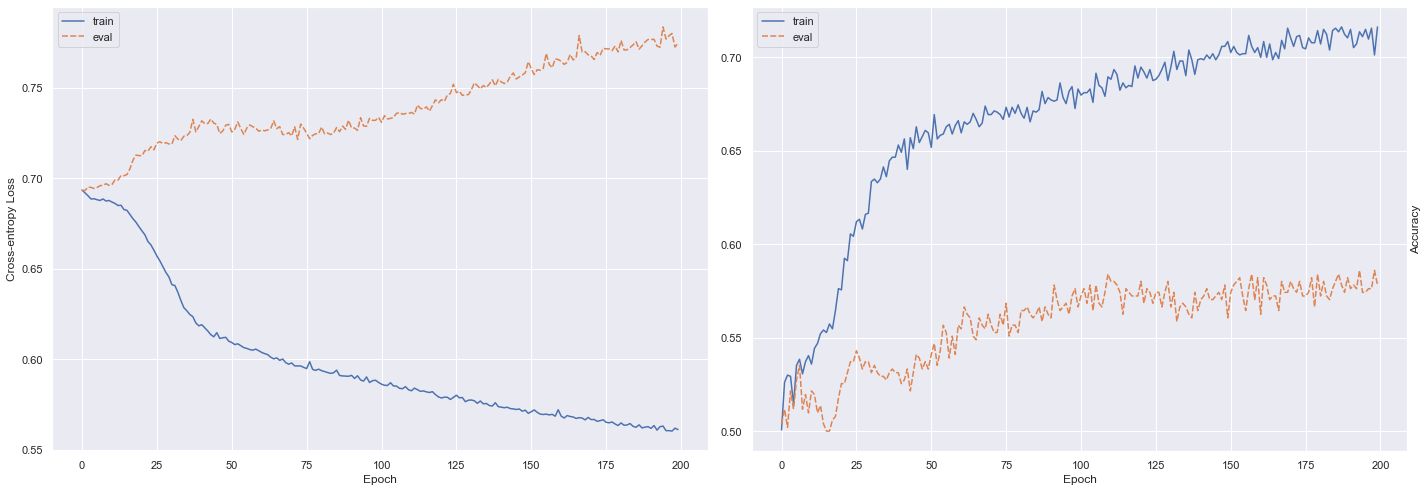

In [11]:
plot_performance(loss=losses, accuracy=accuracies, log_file=f'{log_dir}/hopfield_base.pdf')

<h3 style="color:rgb(0,120,170)">Adapt Hopfield-based Network</h3>
<h3 style="color:rgb(208,90,80)">We can now explore the functionality of our Hopfield layer.</h3>

As described in the paper the Hopfield layer allows:
- association of two sets
- multiple updates
- variable beta
- changing the dimension of the associative space
- pattern normalization
- static patterns for fixed pattern search

This time, additional arguments are set to increase the training as well as the validation performance of the Hopfield-based network.
<br><br>
<table>
    <tr>
        <th>Argument</th>
        <th>Value (used in this demo)</th>
        <th>Description</th>
    </tr>
    <tr>
        <th><code>input_size</code></th>
        <th>num_bits (8)</th>
        <th>Size (depth) of the input (state pattern).</th>
    </tr>
    <tr>
        <th><code>hidden_size</code></th>
        <th>8</th>
        <th>Size (depth) of the association space.</th>
    </tr>
    <tr>
        <th><code>num_heads</code></th>
        <th>8</th>
        <th>Amount of parallel association heads.</th>
    </tr>
    <tr>
        <th><code>update_steps_max</code></th>
        <th>3</th>
        <th>Number of updates in one Hopfield head.</th>
    </tr>
    <tr>
        <th><code>scaling</code></th>
        <th>0.25</th>
        <th>Beta parameter that determines the kind of fixed point.</th>
    </tr>
    <tr>
        <th><code>dropout</code></th>
        <th>0.5</th>
        <th>Dropout probability applied on the association matrix.</th>
    </tr>
    <tr>
        <th><code>...</code></th>
        <th>default</th>
        <th>The remaining arguments are not explicitly used in this example.</th>
    </tr>
</table>

In [12]:
set_seed()
hopfield = Hopfield(
    input_size=bit_pattern_set.num_bits,
    hidden_size=8,
    num_heads=8,
    update_steps_max=3,
    scaling=0.25,
    dropout=0.5)

In [13]:
output_projection = Linear(in_features=hopfield.output_size * bit_pattern_set.num_instances, out_features=1)
network = Sequential(hopfield, Flatten(), output_projection, Flatten(start_dim=0)).to(device=device)
optimiser = AdamW(params=network.parameters(), lr=1e-3)

In [14]:
losses, accuracies = operate(
    network=network,
    optimiser=optimiser,
    data_loader_train=data_loader_train,
    data_loader_eval=data_loader_eval,
    num_epochs=200)

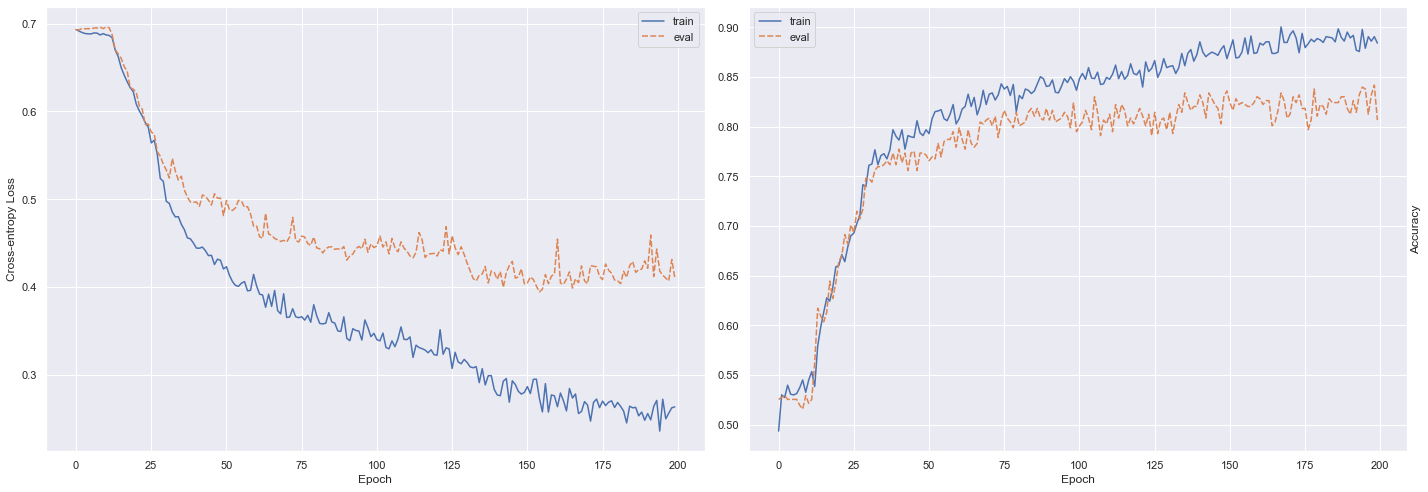

In [15]:
plot_performance(loss=losses, accuracy=accuracies, log_file=f'{log_dir}/hopfield_adapted.pdf')

<h2>Hopfield-based Pooling</h2>

The previous examples manually downprojected the result of <code>Hopfield</code> by applying a linear layer afterwards. It would've also been possible to apply some kind of <i>pooling</i>. Exactly for <i>such</i> use cases, the module <code>HopfieldPooling</code> might be the right choice. Internally, a <i>state pattern</i> is trained, which in turn is used to compute pooling weights with respect to the input.

In [16]:
set_seed()
hopfield_pooling = HopfieldPooling(
    input_size=bit_pattern_set.num_bits)

In [17]:
output_projection = Linear(in_features=hopfield_pooling.output_size, out_features=1)
network = Sequential(hopfield_pooling, output_projection, Flatten(start_dim=0)).to(device=device)
optimiser = AdamW(params=network.parameters(), lr=1e-3)

<h3 style="color:rgb(0,120,170)">Operate Hopfield-based Pooling</h3>

In [18]:
losses, accuracies = operate(
    network=network,
    optimiser=optimiser,
    data_loader_train=data_loader_train,
    data_loader_eval=data_loader_eval,
    num_epochs=200)

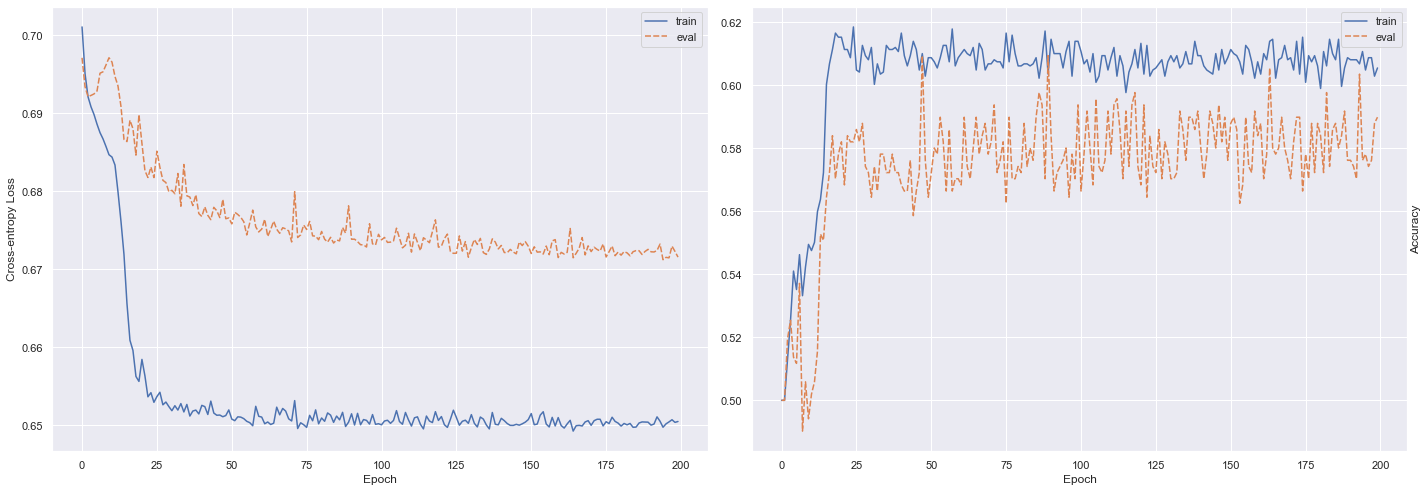

In [19]:
plot_performance(loss=losses, accuracy=accuracies, log_file=f'{log_dir}/hopfield_pooling.pdf')

<h3 style="color:rgb(0,120,170)">Adapt Hopfield-based Pooling</h3>
<h3 style="color:rgb(208,90,80)">We can now again explore the functionality of our Hopfield layer.</h3>

Again, additional arguments are set to increase the training as well as the validation performance of the Hopfield-based pooling.
<br><br>
<table>
    <tr>
        <th>Argument</th>
        <th>Value (used in this demo)</th>
        <th>Description</th>
    </tr>
    <tr>
        <th><code>input_size</code></th>
        <th>num_bits (8)</th>
        <th>Size (depth) of the input (state pattern).</th>
    </tr>
    <tr>
        <th><code>hidden_size</code></th>
        <th>8</th>
        <th>Size (depth) of the association space.</th>
    </tr>
    <tr>
        <th><code>num_heads</code></th>
        <th>8</th>
        <th>Amount of parallel association heads.</th>
    </tr>
    <tr>
    <tr>
        <th><code>update_steps_max</code></th>
        <th>3</th>
        <th>Number of updates in one Hopfield head.</th>
    </tr>
    <tr>
        <th><code>scaling</code></th>
        <th>0.25</th>
        <th>Beta parameter that determines the kind of fixed point.</th>
    </tr>
    <tr>
        <th><code>dropout</code></th>
        <th>0.5</th>
        <th>Dropout probability applied on the association matrix.</th>
    </tr>
    <tr>
        <th><code>...</code></th>
        <th>default</th>
        <th>The remaining arguments are not explicitly used in this example.</th>
    </tr>
</table>

In [20]:
set_seed()
hopfield_pooling = HopfieldPooling(
    input_size=bit_pattern_set.num_bits,
    hidden_size=8,
    num_heads=8,
    update_steps_max=3,
    scaling=0.25,
    dropout=0.5)

In [21]:
output_projection = Linear(in_features=hopfield_pooling.output_size, out_features=1)
network = Sequential(hopfield_pooling, output_projection, Flatten(start_dim=0)).to(device=device)
optimiser = AdamW(params=network.parameters(), lr=1e-3)

In [22]:
losses, accuracies = operate(
    network=network,
    optimiser=optimiser,
    data_loader_train=data_loader_train,
    data_loader_eval=data_loader_eval,
    num_epochs=200)

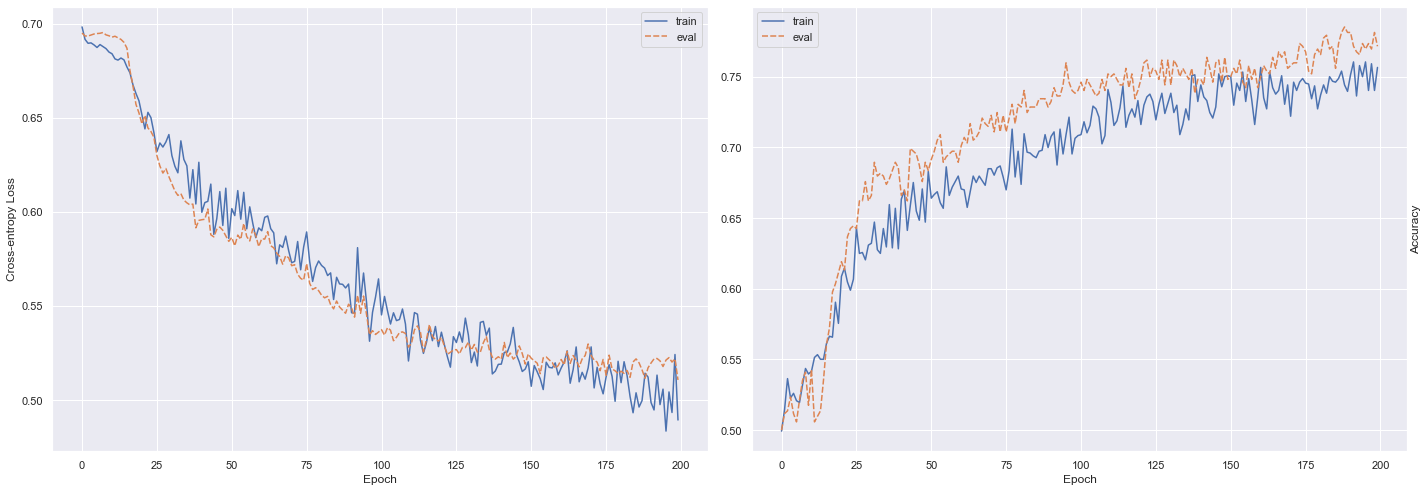

In [23]:
plot_performance(loss=losses, accuracy=accuracies, log_file=f'{log_dir}/hopfield_pooling_adapted.pdf')